In [1]:
# importing cell
from env import *
import numpy as np

# progress bar
import tqdm

# nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from dqn import *

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from itertools import count
import json

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Deep Reinforcement Learning for Snake

## The environment

The `SnakeEnv` is defined in `env.py`. It takes as arguments a render mode implemented with `pygame` (which we set here to `None`), a width and height parameter, a `periodic` flag to allow PBC, and an `observation_type` parameter, which determines if the observation is a simple matrix of -1, 0 and 1 or both the matrix and a direction one-hot encoded vector. 

We choose to have the screen state as the output only, and build a neural network that feeds of a sequence of states (as we will describe later), to see if the neural network understands the concept of direction.

In [2]:
# load config from json file
with open('config.json') as f:
    config = json.load(f)
for k,v in config.items(): print(k,'=',v)

env = {'width': 15, 'height': 15, 'history_length': 2, 'periodic': False, 'food_reward': 10, 'step_penalty': -1, 'terminated_penalty': -10, 'max_steps': 500, 'observation_type': 1}
training = {'buffer_size': 100000, 'batch_size': 256, 'tau': 0.1, 'gamma': 0.99, 'learning_rate': 0.1, 'epsilon': 0.1, 'n_episodes': 500}


Observation shape:
(2, 15, 15)
Latest observation:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


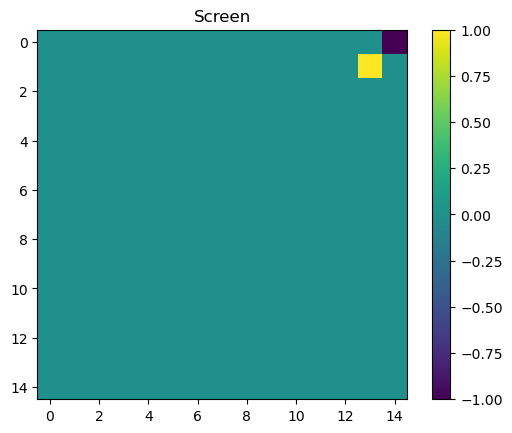

In [3]:
env = SnakeEnv(**config['env'])

obs,_ = env.reset()
print("Observation shape:")
print(obs.shape)
print("Latest observation:")
print(obs[0])
# 1 is the snake, -1 is the food
plt.imshow(obs[0],cmap='viridis')
plt.colorbar()
plt.title('Screen')
plt.show()

## The goal

We take ideas from the <a href="https://arxiv.org/pdf/1312.5602.pdf">Playing Atari with Deep Reinforcement Learning</a> paper. The idea is, always in RL, to approximate and learn the optimal action-value function $Q^*(s,a)$ which is defined as

\begin{equation*}
Q^*(s,a) := \max_{\pi} \mathbb{E} \left [ R_t | s_t = s,a_t=a,\pi \right ]
\tag{1}
\end{equation*}

That is, the optimal value for an action given a certain state is the expected return of taking that action in that state, assuming an ideal policy that maximizes such expected return.
The return is defined as the sum of all rewards from time $t$ up to the end of the episode, discounted with a factor $\gamma$ that regulates the importance of rewards far away in the future: $R_t = \sum_{t'=t}^T \gamma^{t' - t}r_{t'}$. With this definition, and by defining the environment as $\mathcal{E}$, we can rewrite the definition of $Q^*$, using the fundamental recurrence relation that is known as _Bellman's optimality equation_:

\begin{equation*}
Q^*(s,a) = \mathbb{E}_{s' \sim \mathcal{E}} \left [ r + \gamma \max_{a'} Q^*(s',a') | s,a \right ]
\tag{2}
\end{equation*}

In cases where this is computationally feasible, one would often implement the _value iteration algorithm_ by using the equation (2) as a update rule to find the policy that maximizes the value for each state. But that would require keeping a table of values for each $(s,a)$ pair; that is, in many cases, intractable, so an alternative is to use an _approximation_ of the function $Q^*(s,a)$ that computes the value given a certain state using a number of paramters which hopefully is much smaller than the cardinality of the set of all possible states and actions.


## Q-network

In our case, the approximation function is a Convolutional Neural Network (CNN) that feeds on the screen of the game (a 2D matrix of integers). We refer to the neural network function approximator as **Q-network** with weights $\theta$.

#### History of states

But how do we include the information that comes from the snake that is moving? A wall that is 2 steps ahead may be gone by the time the head reaches it. We could encode the information via a numbering system of the pieces of the snake? Or we could follow the prescription of the Atari paper, i.e. the current situation at time $t$ is not fully understood by the screen $x_t$, but by the sequence of states that occurred before. 

Therefore we feed the network not just $x_t$, but an observation of a sequence $s_t = x_{t-k},x_{t-k+1},\dots,x_t$. The Atari paper set $k=4$, i.e. fed the 4 most recent frames to the network.

#### Action as input or output?

When modeling the function $Q(s,a)$, should the action $a$ be fed as an input like the state $s$? That would be coherent with the mathematical formulation, but it would be complicated since we need to mix convolutional features with this parameter, and also computationally disadvantageous, since to compute the value for every single action we need to feed forward every time. What we can do instead is to build the network to have $n_a$ output neurons, one for each action, given a certain state.

#### `PyTorch` implementation

We will use the [PyTorch](https://pytorch.org/) library to build the neural network. We will stack several [convolutional layers](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with different number of kernels, with a final [feed forward hidden layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to model the $Q(s,a)$. The Q-network model is defined in `dqn.py`.

In [4]:
# obs is of shape (history,W,H)
obs,_=env.reset(seed=1235)

# to feed it to the NN we need ad additional first dimension for batch size. example a batch of 3
obs_batch = np.stack((obs,obs,obs),0)

# output
model = DQN(config['env']['history_length'])
model(obs_batch)

tensor([[ 0.0327,  0.1199, -0.0511,  0.0356],
        [ 0.0327,  0.1199, -0.0511,  0.0356],
        [ 0.0327,  0.1199, -0.0511,  0.0356]], grad_fn=<AddmmBackward0>)

In [5]:
for name,param in model.named_parameters():
    print(name)
    print(param.shape)

conv1.weight
torch.Size([15, 2, 3, 3])
conv1.bias
torch.Size([15])
conv2.weight
torch.Size([15, 15, 7, 7])
conv2.bias
torch.Size([15])
conv3.weight
torch.Size([15, 15, 2, 2])
conv3.bias
torch.Size([15])
ffl1.weight
torch.Size([256, 15])
ffl1.bias
torch.Size([256])
ffl2.weight
torch.Size([4, 256])
ffl2.bias
torch.Size([4])


## Training

The Q-network, as previously stated, is an approximation of the more general $Q(s,a)$, for which we cannot know every single value without a functional form (i.e. in a tabular way). Our hope is that the model, given some observed data of the $Q^*(s,a)$, will be able to generalize to unseen states. $Q_{\pi}(s,a)$ is the expected return in a state given an action when following a policy $\pi$; when $\pi$ is assumed to be the optimal policy (the one that maximizes the return), the $Q^*(s,a)$ obeys the Bellman optimality equation we saw earlier.

What is usually done, in tabular approaches, is to estimate the $Q_\pi$ either via Monte Carlo sampling (running episodes following $\pi$ and computing the returns) or via bootstrapping using TD methods, so using some level of the Bellman equation like 
\begin{equation*}
Q_{i+1}(s,a) = \mathbb{E}[r + \gamma \max_{a'}Q_i(s',a')|s,a]
\tag{2b}
\end{equation*}

When the next action is taken to be $\argmax_{a'} Q(s',a')$, the previous equation estimates $Q$ using an **on-policy** method (SARSA), but more often than not the next action is not taken as a greedy action, but it's usually a *behaviour policy*, like an $\epsilon$ greedy policy.

When we use an approximation of the function $Q$, we need to fit it to the data that represents the return, i.e. we need to minimize the following loss:

\begin{equation*}

L_i (\theta_i) := \mathbb{E}_{s,a\sim \rho (\cdot)} \left [ (y_i - Q(s,a;\theta_i))^2 \right ]

\tag{3}
\end{equation*}
with $y_i$ being the *target*: 
\begin{equation*}
y_i := \mathbb{E}_{s' \sim \mathcal{E}} \left [ r + \gamma \max_{a'} Q(s',a';\theta_{i-1}) | s,a \right ]
\tag{4}
\end{equation*}

as we can see, the target depends on the expected reward and the estimation of the next state value given optimality (and NOT the action picked by the behaviour policy!).

When computing the gradient to minimize such loss, we have

\begin{equation*}
\nabla_{\theta_i} L_i (\theta_i) = \mathbb{E}_{s,a \sim \rho (\cdot); s' \sim \mathcal{E}} \left [ \left ( r + \gamma \max_{a'} Q(s',a';\theta_{i-1}) - Q(s,a;\theta_{i}) \right ) \nabla_{\theta_i} Q(s,a;\theta_i) \right ]
\tag{5}
\end{equation*}

Typically, the loss is calculated on a dataset of $(s,a,r,s')$, but it is more feasible to compute it on just a subset of it; when the subset consists of a single sample from the behavioural distribution and the environment, and we update the weights each time step, we arrive at the well known *Q-learning* algorithm.


### Experience replay

Instead of using the sequence of $(s,a,r,s')$ as they are generated, we store them in a *replay memory*, from which we randomly sample a minibatch to perform the update in (5). This has several advantages over the standard online Q-learning: first, the transitions are re-used, to allow a greater data efficiency; second, and most important, the stochastic gradient descent works best when the samples of the expectation are i.i.d., which is **not** the case for subsequent states observed in an episode, which are highly correlated.

#### Implementation

We will implement the replay memory as a `torch.utils.data.Dataset` class, that holds the transitions and supports interaction with `torch.utils.data.DataLoader` for batching and shuffling.

In [6]:
class ReplayMemory(Dataset):

    def __init__(self,max_capacity):
        
        # init max_capacity
        self.max_capacity = max_capacity
        # init samples as empty lists
        self.s = []
        self.a = []
        self.r = []
        self.s2 = []
        self.terminal = []
    
    def __len__(self):
        return len(self.s) # return length of one of the lists
    
    def __getitem__(self,idx):
        
        sample = {
            's' : self.s[idx],
            'a' : self.a[idx],
            'r' : self.r[idx],
            's2' : self.s2[idx],
            'terminal' : self.terminal[idx]
        }

        return sample

    def _add_sample(self,s,a,r,s2,terminal):
        """
        s and s2 are numpy arrays of shape (history_len,width,height)
        a is an int
        r is float
        """
        self.s.append(s)
        self.a.append(a)
        self.r.append(r)
        self.s2.append(s2)
        self.terminal.append(terminal)
        
        if self.__len__() > self.max_capacity:
            random_drop = np.random.randint(0,self.max_capacity)
            self.s.pop(random_drop)
            self.a.pop(random_drop)
            self.r.pop(random_drop)
            self.s2.pop(random_drop)



#### Policy functions

In [7]:
def random_policy():
    return np.random.randint(4)

def epsilon_greedy_policy(state,epsilon,net):
    if isinstance(state,dict):
        raise NotImplementedError()
    else:
        if np.random.rand() < epsilon:
            return random_policy()
        else:
            with torch.no_grad(): # disable gradient calculations. useful when doing inference to skip computation
                # find the maximum over the action dim for each batch sample
                # but batch_size is one in inference so expand dims
                q = net(np.expand_dims(state,axis=0))
                a = q.argmax(1).item() 
                return a # is an int
            

def play_episode(policy,env,memory=None,**policy_kwargs):
    """
    Play an episode following a given policy, and if ReplayMemory is given adds (s,a,r,s2) transitions to it.
    Args:
    -----
        policy : func, receives a state and returns an action
        memory : ReplayMemory instance
    Returns:
    -----
        episode : list of [(s,a,r,s2,done)] tuples
    """
    done = False
    episode = []
    while not done:
        s,_=env.reset()
        
        a = policy(s,**policy_kwargs)

        s2,r,done,_=env.step(a)

        if memory is not None:
            memory._add_sample(s,a,r,s2,done)
        episode.append((s,a,r,s2))
    return episode


In [8]:
# play some episodes with a random policy to demonstrate the DataLoader class
REPLAY_MEMORY = ReplayMemory(2000)
N_EPISODES = 50

for i in tqdm.trange(N_EPISODES):
    # e=play_episode(lambda s : np.random.randint(4),env,REPLAY_MEMORY)
    e = play_episode(epsilon_greedy_policy,env,REPLAY_MEMORY,epsilon=0.1,net=model)

#
print("Replay Memory size:\n   ", REPLAY_MEMORY.__len__())
# now, data_loader is an iterable, and can be used to generate random batches of samples from the replay memory
REPLAY_LOADER = DataLoader(REPLAY_MEMORY,batch_size=20,shuffle=True)
# as we can see, the shape of one batch of screen inputs is (batch_size,history_length,width,height)
print('DataLoader screen sample shape:\n   ',next(iter(REPLAY_LOADER))['s'].shape)
print('DataLoader terminal sample shape:\n   ',next(iter(REPLAY_LOADER))['terminal'].shape)



100%|██████████| 50/50 [00:00<00:00, 148.80it/s]

Replay Memory size:
    891
DataLoader screen sample shape:
    torch.Size([20, 2, 15, 15])
DataLoader terminal sample shape:
    torch.Size([20])


### Loop

Now that we defined the network $Q(s,a,\theta)$, the replay buffer $\mathcal{D}$, its loader, and the epsilon greedy policy function as an epsilon greedy policy (purely greedy policy means setting $\epsilon=0$), we can run the training loop. To compute the loss we will use PyTorch's `nn.MSELoss()`, so that we can call the optimizer `optim.Adam` on it.

In [9]:
# loop parameters
N_EPISODES=config['training']['n_episodes']
EPSILON=config['training']['epsilon']
TAU=config['training']['tau']

LR = config['training']['learning_rate']
BATCH_SIZE = config['training']['batch_size']

GAMMA=config['training']['gamma']
BUFFER_SIZE=config['training']['buffer_size']

In [14]:
# thetai and thetai-1
policy_net = DQN(history_length=config['env']['history_length']) # theta i
target_net = DQN(history_length=config['env']['history_length']) # theta i-1, used to compute the target yi
# initially clone them
target_net.load_state_dict(policy_net.state_dict())

# Adam optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
# replay memory
REPLAY_MEMORY = ReplayMemory(BUFFER_SIZE)

Recall the definition of loss in equation (5):

\begin{equation*}

L_i (\theta_i) := \mathbb{E}_{s,a\sim \rho (\cdot)} \left [ (y_i - Q(s,a;\theta_i))^2 \right ]

\tag{3}
\end{equation*}
with $y_i$ being the *target* that uses the previous estimate of $Q$: 
\begin{equation*}
y_i := \mathbb{E}_{s' \sim \mathcal{E}} \left [ r + \gamma \max_{a'} Q(s',a';\theta_{i-1}) | s,a \right ]
\tag{4}
\end{equation*}
or just $r$ if the state is terminal.

In [19]:
def optimize_model():
    if REPLAY_MEMORY.__len__() < BATCH_SIZE:
        # do not optimize if we do not have enough samples
        return
    # data loader
    data_loader = DataLoader(REPLAY_MEMORY,BATCH_SIZE,True)

    # get a batch
    batch=next(iter(data_loader))


    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.logical_not(batch['terminal'])
    non_final_next_states = batch['s2'][non_final_mask]
    state_batch = batch['s']
    action_batch = batch['a']
    reward_batch = batch['r']

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch.numpy()).gather(1,action_batch[:,None])

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        # compute
        next_state_values[non_final_mask] = target_net(non_final_next_states.numpy()).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute loss
    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [20]:
episode_durations=[]

for i_episode in tqdm.trange(N_EPISODES):

    state,_ = env.reset()
    for t in count():
        action = epsilon_greedy_policy(state,epsilon=EPSILON,net=policy_net)
        next_state, reward, done, _ = env.step(action)



        # Store the transition in memory
        REPLAY_MEMORY._add_sample(state,action,reward,next_state,done)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        if done:
            episode_durations.append(t+1)
            break



100%|██████████| 500/500 [01:01<00:00,  8.19it/s]


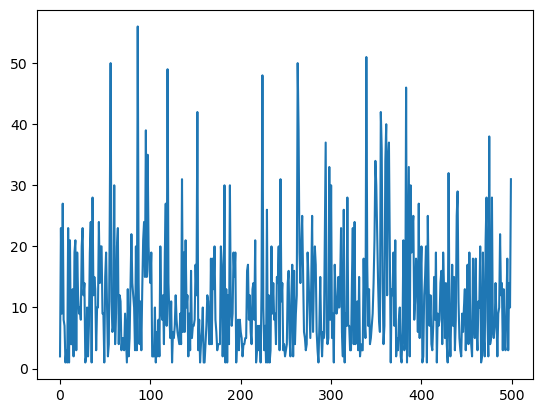

In [21]:
plt.plot(episode_durations)

In [22]:
torch.save(policy_net,'./checkpoint/policy_net.pth')